# Finding Lane Lines on the Road

## 1. The Pipeline

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

### Step 0: Input

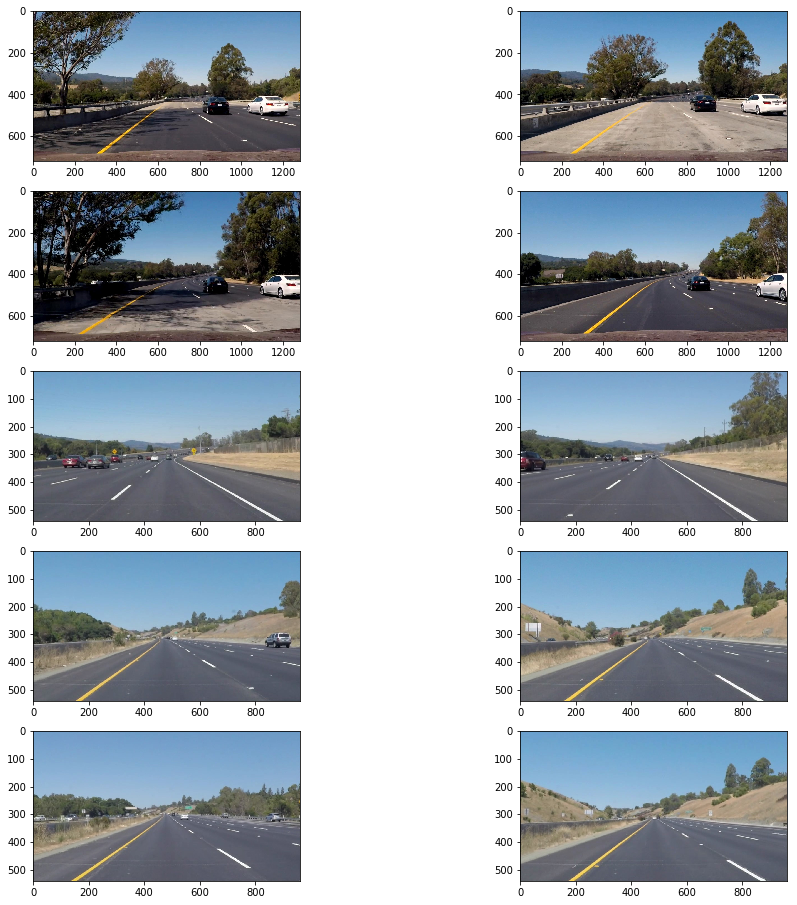

In [2]:
import glob

# reading test images
imgs = [mpimg.imread(img_dir) for img_dir in glob.glob('test_images/*')]

# show a group of images
def show_images(imgs, cmap=None):
    cols = 2
    rows = (len(imgs)+cols-1)//cols
    
    plt.figure(figsize=(16,16))
    for i in range(len(imgs)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i], cmap)
    plt.show()

# show all test images
show_images(imgs)

### Step 1: Image Stats

In [3]:
def stat(img):
    height, width, channel = img.shape[0], img.shape[1], img.shape[2]
    return height, width, channel

for img in imgs:
    height, width, channel = stat(img)
    print("Image is of type:", type(img), "height:", height, "width:", width, "channel:", channel)


Image is of type: <class 'numpy.ndarray'> height: 720 width: 1280 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 720 width: 1280 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 720 width: 1280 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 720 width: 1280 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3
Image is of type: <class 'numpy.ndarray'> height: 540 width: 960 channel: 3


### Step 2: Filter Color

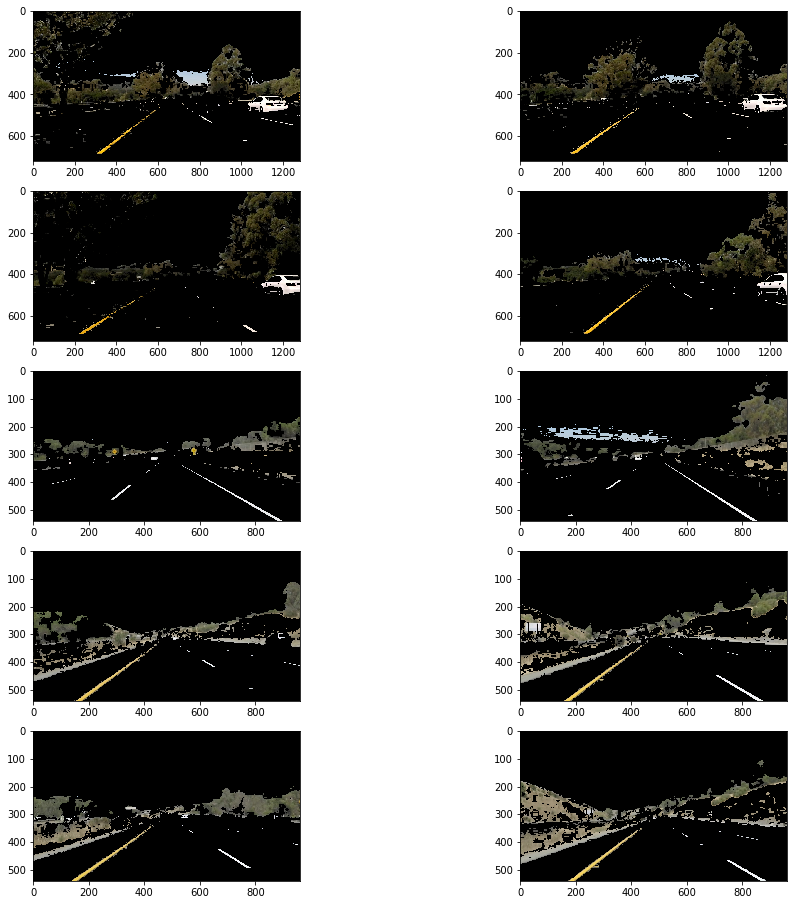

In [4]:
def color_selection(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # select yellow color
    # Yellow Hue: 60 degree => H/2 (opencv's hue representation) => ~30
    # H = [20, 40]
    lower = np.uint8([20,   0, 0])
    upper = np.uint8([40, 255, 255])
    yellow_mask = cv2.inRange(lab, lower, upper)
    
    # select white color
    # High Lightness L = [200, 255]
    lower = np.uint8([0,   200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(lab, lower, upper)
    
    combine_mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combine_mask)
    

color_imgs = [color_selection(img) for img in imgs]
show_images(color_imgs)

### Step 2:  Gray Scale

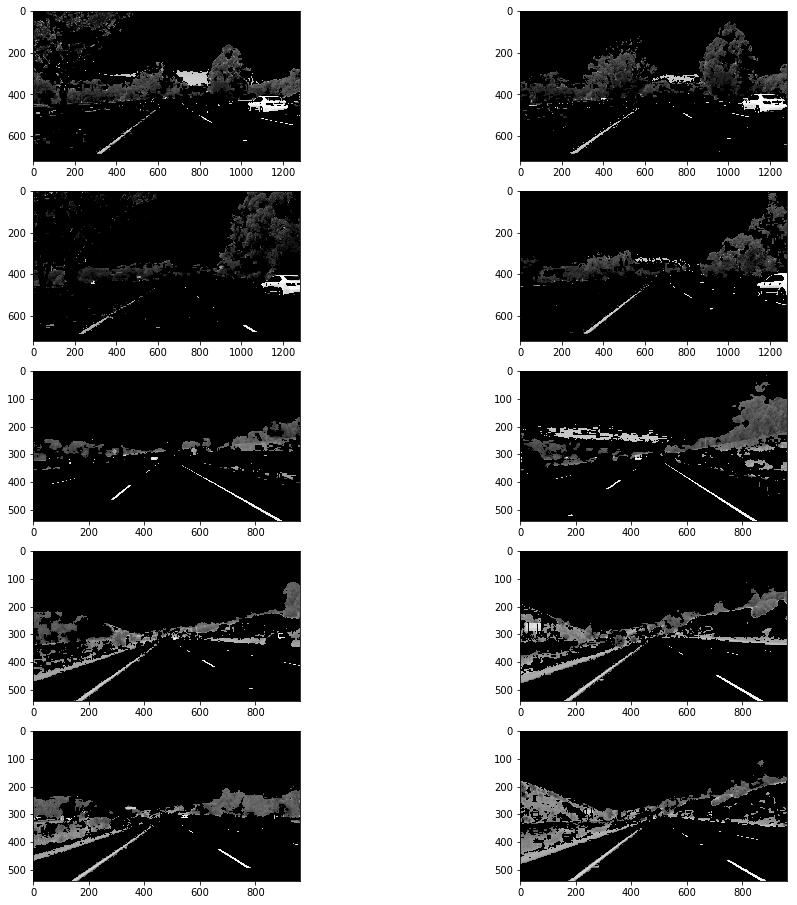

In [5]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

gray_imgs = [grayscale(img) for img in color_imgs]
show_images(gray_imgs, 'gray')

### Step 3: Gaussian Blur

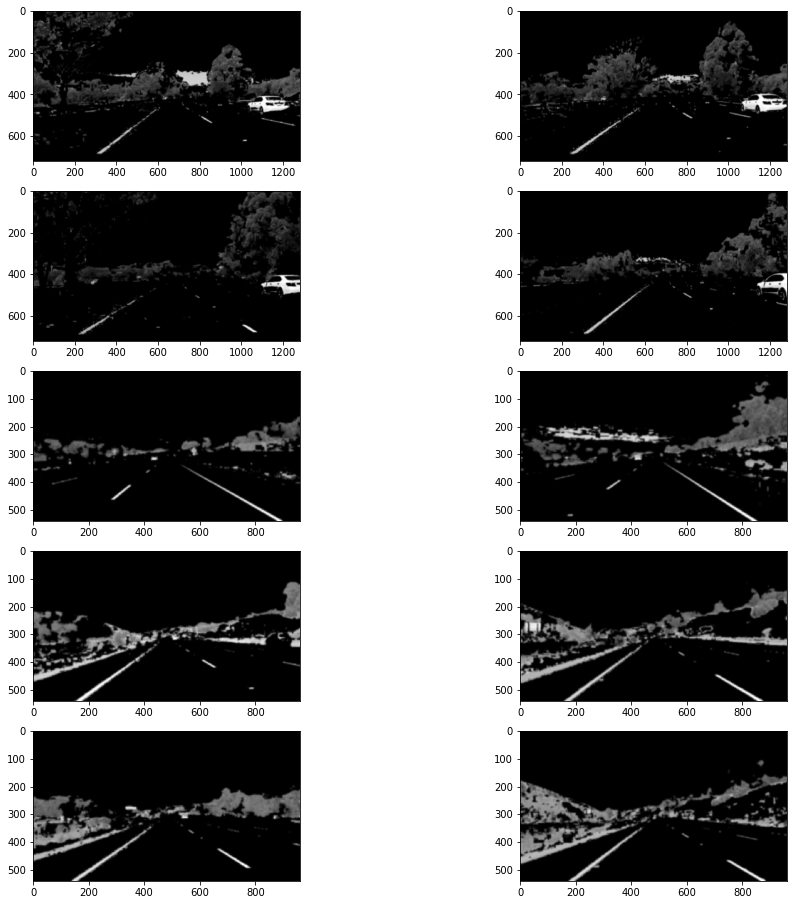

In [6]:
def gaussian_blur(img):
    return cv2.GaussianBlur(img, (15, 15), 0)

blur_imgs = [gaussian_blur(gray_img) for gray_img in gray_imgs]
show_images(blur_imgs, 'gray')

### Step 4: Canny Edge

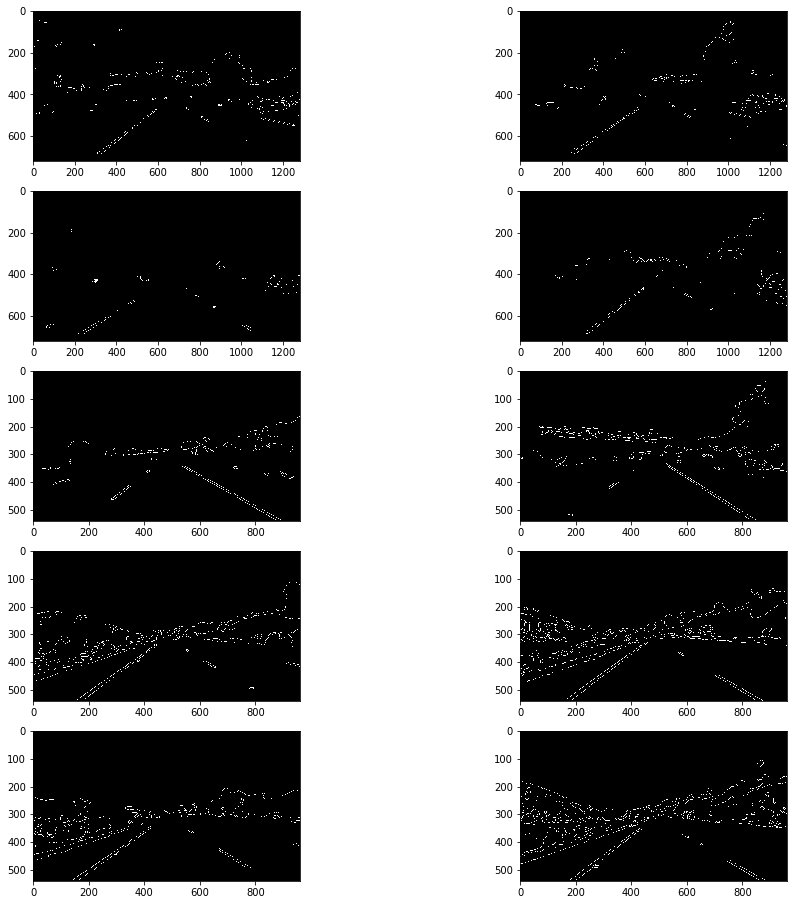

In [7]:
def canny(img):
    return cv2.Canny(img, 50, 150)

canny_edges = [canny(blur_img) for blur_img in blur_imgs]
show_images(canny_edges, 'gray')

### Step 5: Region of Interest

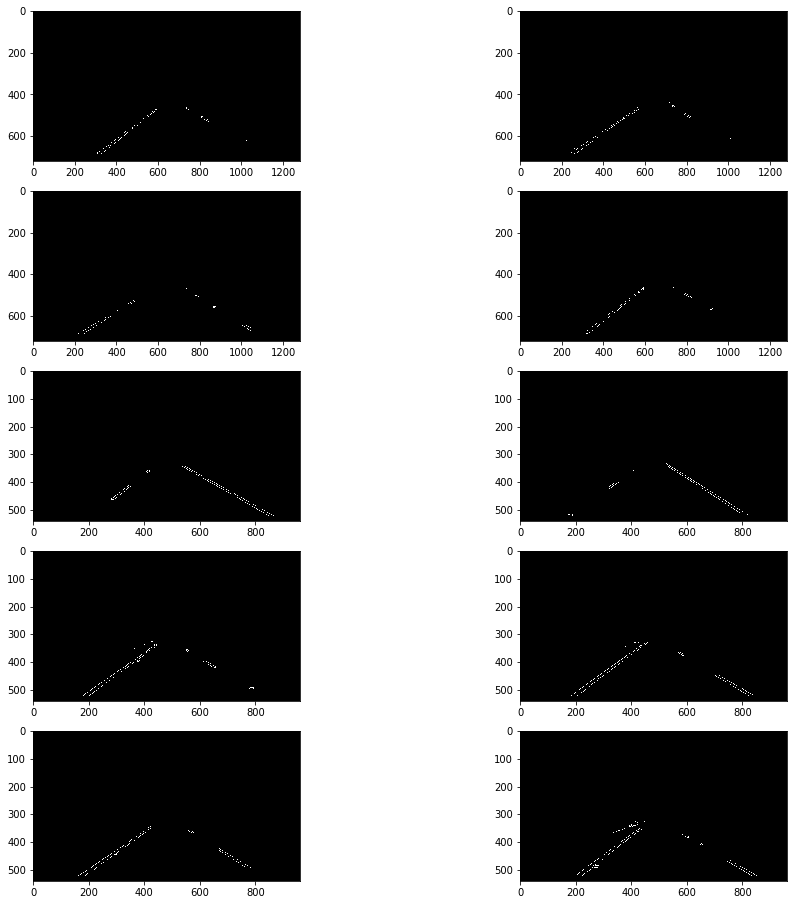

In [8]:
# vertices should be in percentage rather than hardcoded pixels
def compute_vertices(width, height):
    padding_bot_x, padding_bot_y, mid_offset_x, mid_offset_y = width/30, height/30, width/15, height/10
    return [np.array([[0+padding_bot_x, height-padding_bot_y], [width/2-mid_offset_x, height/2+mid_offset_y], 
        [width/2+mid_offset_x, height/2+mid_offset_y], [width-padding_bot_x, height-padding_bot_y]],np.int32)]

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    height, width = img.shape[0], img.shape[1]
    vertices = compute_vertices(width, height)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #plt.imshow(mask, 'gray')
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

masked_imgs = [region_of_interest(canny_edge) for canny_edge in canny_edges]
show_images(masked_imgs, 'gray')

### Step 6: Hough Line

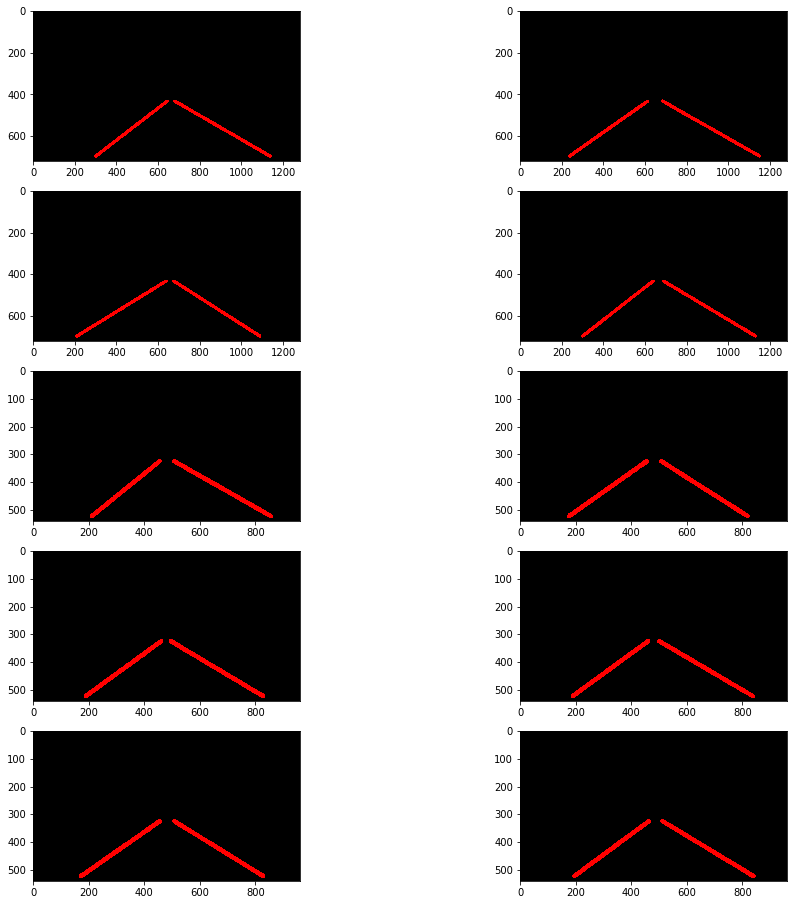

In [9]:
import math
def hough_lines(img):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    rho, theta, threshold, min_line_len, max_line_gap = 1, np.pi/180, 25, 15, 100
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    height, width = img.shape[0], img.shape[1]
    vertices = compute_vertices(width, height)
    
    if lines is not None:
        draw_lines(line_img, vertices, lines, thickness=15)
    return line_img

def draw_lines(img, vertices, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # y = kx + b
    left_k, left_b, left_len, right_k, right_b, right_len = [], [], [], [], [], []
    for line in lines:
        for x1,y1,x2,y2 in line:
            length = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
            k = (y1 - y2)/(x1 - x2)
            b = y1 - k * x1
            if np.isnan(k) or np.isinf(k):
                continue
            if k > 0:
                right_k.append(k)
                right_b.append(b)
                right_len.append(length)
            elif k < 0:
                left_k.append(k)
                left_b.append(b)
                left_len.append(length)
            
    left_weights, right_weights = left_len/np.sum(left_len), right_len/np.sum(right_len)
    avg_left_k, avg_left_b = np.dot(left_k, left_weights), np.dot(left_b, left_weights)
    avg_right_k, avg_right_b = np.dot(right_k, right_weights), np.dot(right_b, right_weights)
    
    # compute intersections
    # [[a, b],[c, d],[e, f],[h, i]]
    y_top, y_down = vertices[0][1][1], vertices[0][0][1]
    x_top_left, x_down_left = (y_top - avg_left_b)/avg_left_k, (y_down - avg_left_b)/avg_left_k
    x_top_right, x_down_right = (y_top - avg_right_b)/avg_right_k, (y_down - avg_right_b)/avg_right_k
    
    if len(left_k) != 0:
        cv2.line(img, (int(x_top_left), int(y_top)), (int(x_down_left), int(y_down)), color, thickness)
    if len(right_k) != 0:
        cv2.line(img, (int(x_top_right), int(y_top)), (int(x_down_right), int(y_down)), color, thickness)
    
    
    # debugging lines
    #for line in lines:
    #    for x1, y1, x2, y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), [0,0,255], 2)

# detect and draw lines            
line_imgs = [hough_lines(masked_img) for masked_img in masked_imgs]

show_images(line_imgs)

### Step 7: Annotate Lanes

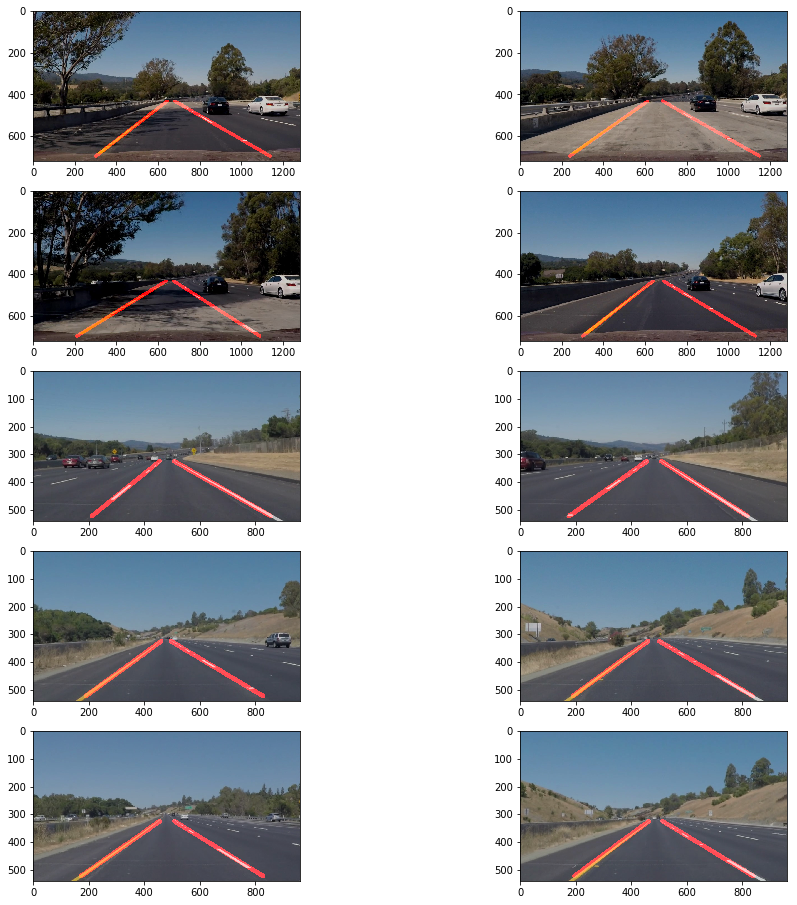

In [10]:
def annotate_lanes(img, line_img):
    # alpha blending
    return cv2.addWeighted(img, 0.8, line_img, 1.0, 0)

finals = [annotate_lanes(img, line_img) for img, line_img in zip(imgs, line_imgs)]
show_images(finals)

### Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

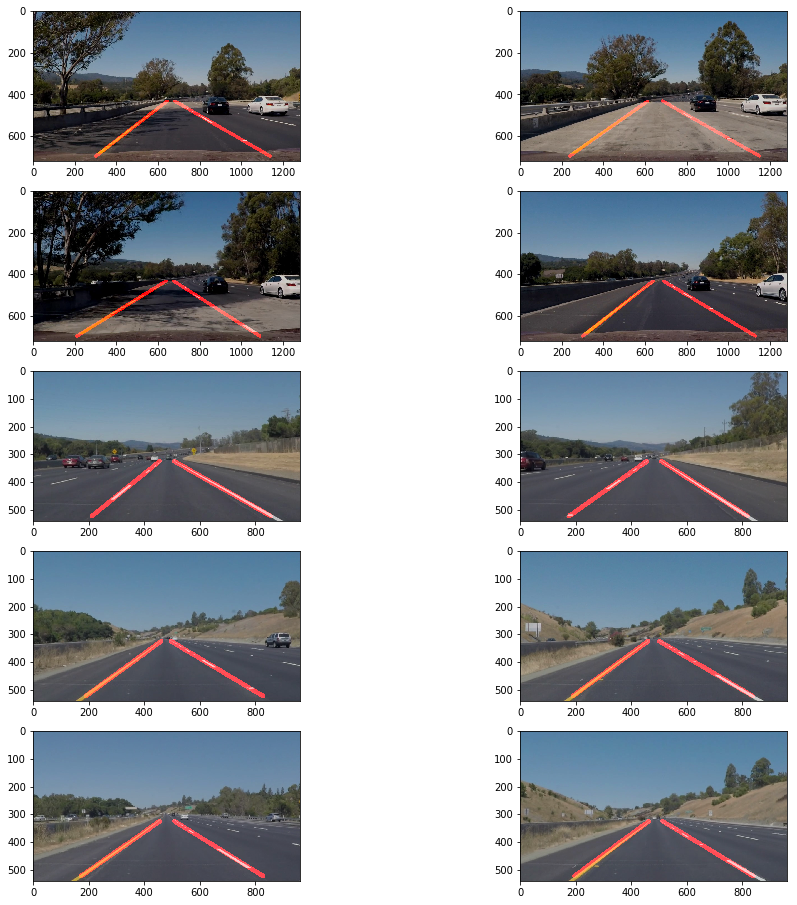

In [11]:
def pipeline(image):
    height, width, channel = stat(image)
    # convert color spaces
    color = color_selection(image)
    # convert to gray scale image
    gray = grayscale(color)
    # blur
    blur = gaussian_blur(gray)
    # edge detection
    edge = canny(blur)
    # mask ('vertices' is coming from 'Region of Interest' section)
    masked_img = region_of_interest(edge)
    # hugh transform, finding lines
    line_img = hough_lines(masked_img)
    # blend in annotation
    final = annotate_lanes(image, line_img)
    return final

processed_imgs = [pipeline(img) for img in imgs]
show_images(processed_imgs)

### Videos

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return pipeline(image)

Let's try the one with the solid white lane on the right first ...

In [14]:
def process_video(input_dir, output_dir):
    ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
    ## To do so add .subclip(start_second,end_second) to the end of the line below
    ## Where start_second and end_second are integer values representing the start and end of the subclip
    ## You may also uncomment the following line for a subclip of the first 5 seconds
    ##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
    clip1 = VideoFileClip(input_dir)
    white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output_dir, audio=False)

## 2. Results

### Result 1: Solid White Right

In [15]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
process_video('test_videos/solidWhiteRight.mp4', white_output)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:09<00:00, 25.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.32 s, sys: 1.53 s, total: 7.85 s
Wall time: 10.2 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Result 2: Solid Yellow Left

In [17]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
process_video('test_videos/solidYellowLeft.mp4', yellow_output)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:35<00:00, 21.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 20.6 s, sys: 4.89 s, total: 25.5 s
Wall time: 36.1 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Result 3: Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
process_video('test_videos/challenge.mp4', challenge_output)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:23<00:00, 12.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 12.9 s, sys: 3.36 s, total: 16.2 s
Wall time: 25.5 s


In [20]:
#clip = VideoFileClip('test_videos/challenge.mp4')
#clip.write_images_sequence('frames/frame%04d.jpg')
        

In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))